In [13]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import seaborn as sns

In [14]:

categories = [
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'alt.atheism',
 'soc.religion.christian',
]
dataset = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, remove=('headers', 'footers', 'quotes'))

df = pd.DataFrame(dataset.data, columns=["corpus"])
print(df)

                                                 corpus
0     \nThey tried their best not to show it, believ...
1     \nStankiewicz?  I doubt it.\n\nKoufax was one ...
2     \n[deletia- and so on]\n\nI seem to have been ...
3     Excuse the sheer newbieness of this post, but ...
4     ==============================================...
...                                                 ...
3446  \n  Or, with no dictionary available, they cou...
3447  \n\nSorry to disappoint you but the Red Wings ...
3448  \n: Can anyone tell me where to find a MPEG vi...
3449                                                 \n
3450  \nHey Valentine, I don't see Boston with any w...

[3451 rows x 1 columns]


In [15]:
df.describe()


,corpus
count,3451
unique,3362
top,
freq,66


In [16]:
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [18]:
import nltk
from nltk.corpus import stopwords
stopwords.words("english")[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [19]:
def preprocess_text(text: str, remove_stopwords: bool) -> str:
    text = re.sub(r"http\S+", "", text)
    text = re.sub("[^A-Za-z]+", " ", text)
    if remove_stopwords:
        tokens = nltk.word_tokenize(text)
        tokens = [w for w in tokens if not w.lower() in stopwords.words("english")]
        text = " ".join(tokens)
    text = text.lower().strip()
    return text


In [20]:
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [21]:
df['cleaned'] = df['corpus'].apply(lambda x: preprocess_text(x, remove_stopwords=True))
print(df)

                                                 corpus  \
0     \nThey tried their best not to show it, believ...   
1     \nStankiewicz?  I doubt it.\n\nKoufax was one ...   
2     \n[deletia- and so on]\n\nI seem to have been ...   
3     Excuse the sheer newbieness of this post, but ...   
4     ==============================================...   
...                                                 ...   
3446  \n  Or, with no dictionary available, they cou...   
3447  \n\nSorry to disappoint you but the Red Wings ...   
3448  \n: Can anyone tell me where to find a MPEG vi...   
3449                                                 \n   
3450  \nHey Valentine, I don't see Boston with any w...   

                                                cleaned  
0     tried best show believe surprised find sprint ...  
1     stankiewicz doubt koufax one two jewish hofs h...  
2     deletia seem rather unclear asking please show...  
3     excuse sheer newbieness post looking decent pa...  
4

In [22]:
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.95)
X = vectorizer.fit_transform(df['cleaned'])

In [23]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X)
clusters = kmeans.labels_

from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
pca_vecs = pca.fit_transform(X.toarray())
x0 = pca_vecs[:, 0]
x1 = pca_vecs[:, 1]

df['cluster'] = clusters
df['x0'] = x0
df['x1'] = x1
print(df)

                                                 corpus  \
0     \nThey tried their best not to show it, believ...   
1     \nStankiewicz?  I doubt it.\n\nKoufax was one ...   
2     \n[deletia- and so on]\n\nI seem to have been ...   
3     Excuse the sheer newbieness of this post, but ...   
4     ==============================================...   
...                                                 ...   
3446  \n  Or, with no dictionary available, they cou...   
3447  \n\nSorry to disappoint you but the Red Wings ...   
3448  \n: Can anyone tell me where to find a MPEG vi...   
3449                                                 \n   
3450  \nHey Valentine, I don't see Boston with any w...   

                                                cleaned  cluster        x0  \
0     tried best show believe surprised find sprint ...        0 -0.001520   
1     stankiewicz doubt koufax one two jewish hofs h...        0 -0.036450   
2     deletia seem rather unclear asking please show...  

In [24]:
def get_top_keywords(n_terms):
    df = pd.DataFrame(X.todense()).groupby(clusters).mean()
    terms = vectorizer.get_feature_names_out() 
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([terms[t] for t in np.argsort(r)[-n_terms:]])) 
            
get_top_keywords(10)


Cluster 0
good,last,games,like,would,year,think,one,team,game

Cluster 1
please,dos,use,know,program,anyone,files,file,thanks,windows

Cluster 2
christians,say,think,bible,believe,jesus,one,would,people,god


In [25]:
cluster_map = {0: "Sports", 1: "Technology", 2: "Religion"}                          
df['cluster'] = df['cluster'].map(cluster_map)

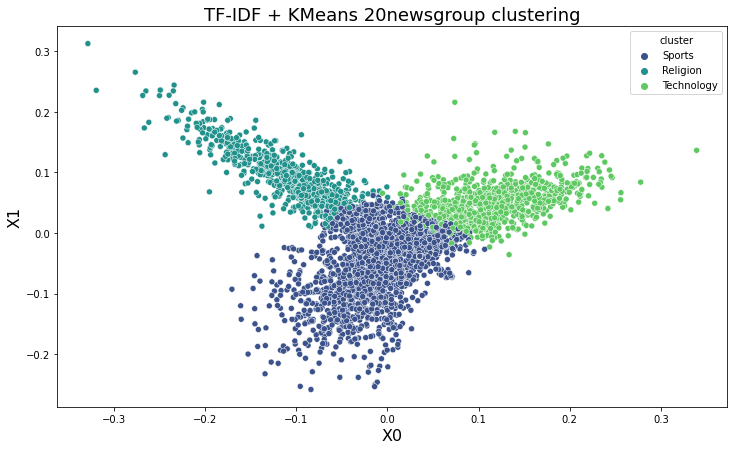

In [26]:
# set image size
plt.figure(figsize=(12, 7))
# set a title
plt.title("TF-IDF + KMeans 20newsgroup clustering", fontdict={"fontsize": 18})
# set axes names
plt.xlabel("X0", fontdict={"fontsize": 16})
plt.ylabel("X1", fontdict={"fontsize": 16})
# create scatter plot with seaborn, where hue is the class used to group the data
sns.scatterplot(data=df, x='x0', y='x1', hue='cluster', palette="viridis")
plt.show()